# Debate analysis example

In this notebook we present an example of how to evaluate the aspects we defined on shprt debate. We will use as example a the topic of Universal Basic Income. 
We will use three different debates: 
* one from [Wikidebate](https://en.wikiversity.org/wiki/Category:Wikidebates) titled ['_Should universal basic income be established?_'](https://en.wikiversity.org/wiki/Should_universal_basic_income_be_established%3F)
* one from [Kialo](https://www.kialo.com) titled ['_Should governments provide a universal basic income?_'](https://www.kialo.com/should-governments-provide-a-universal-basic-income-14053)
* one from [/rchangemyview](https://www.reddit.com/r/changemyview/) titled ['_CMV: Universal basic income is the way of the future._'](https://www.reddit.com/r/changemyview/comments/tdmuae/cmv_universal_basic_income_is_the_way_of_the/).

For further general information on data collection see the readme file and `src/data_collection/` folder for the code.

We start by importing all the functions we will use to evaluate the defined metrics.

In [1]:
from src.complexity_utils import *
from src.disagreement_utils import *
from src.equality_engagement_utils import *
from src.reason_utils import *
from src.sentiment_utils import *
from src.sourcing_utils import *
from src.topic_distance_utils import *
from src.plot_utils import *

from sentence_transformers import SentenceTransformer,util,SimilarityFunction
from transformers import AutoTokenizer

import pandas as pd

2025-09-15 16:19:04.517436: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-15 16:19:04.517470: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-15 16:19:04.518879: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-15 16:19:04.526553: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-15 16:19:06.812634: W tensorflow/comp

We proceeed to import the data we need. In this notebook we have three separated csv files, each row of these files contain a post, which is assigned with the following infomration:
* **id**: a unique id identifying the post
* **page_id**: an id identifying the topic 
* **item**: the content of the post
* **parent_id**: the id of the parent post, in the case of root post this value is 0
* **title**: a title identifying the topic
* **debate_id**: an id identifying the debate (as Kialo and CMV in the original dataset may have different debates for the same topic)
* **length**: post length in charachters
* **level**: depth level of the post (root posts are assigned with a level of 0)
* **thread_id**: an id identifying the thread each post belongs to
* **author**: author(s) of the post, in the case of Wikidebate more than one user could be involved. In the case of Kialo we cannot associate each post with its authors, thus this column is assigned with Nan values, while we use unmatched statistics when needed.
* **platform**: short name of the platform the post was published in. 
* **stance**: the stance the post express respect to its parent post. In the cases of Wikidebate and Kialo it is made explicit by the platform and we just collected that information, in the case of CMV we assigned the stance using an OpenAI LLM model. The code used to do that can be found in `debate-analysis/src/disagreement_utils.py`

Moreover Canghe My View has:

* **original_item**: post content before preprocessing, used to extract references. 

In [2]:
platforms=['wiki','kialo','cmv']
wiki_data=pd.read_csv('data/UBI_wiki.csv',index_col=0)
kialo_data=pd.read_csv('data/UBI_kialo.csv',index_col=0)
cmv_data=pd.read_csv('data/UBI_cmv.csv',index_col=0)
merged_data = pd.concat([wiki_data,kialo_data,cmv_data],ignore_index=True)

We also create an empty dataframe to collect all the scores we will compute

In [3]:
scores_data_frame = pd.DataFrame(index=["wiki", "kialo", "cmv"])

### Engagement & Equality
We now evaluate the engagement and the equality score for our data. 

We measure the engagement in each debate as the ratio between the number of unique users who contributed to the debate and the number of posts, while the equality by computing the Gini index over the participation metrics of the users in each debate and subtracting it from 1

The function `engagement_and_equality` provide us with two lists: the first one contains engagement scores for respectively Wikidebate, Kialo and CMV, while the second equality scores in the same order of appereance

In [4]:
engagement_scores,equality_scores=engagement_and_equality_assignment(merged_data,platforms)
scores_data_frame = scores_data_frame.assign(engagement_score = engagement_scores, equality_score=equality_scores)

/data/big/wikidebate/debate-analysis/src/equality_engagement_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wiki_data['author']=wiki_data['author'].apply(ast.literal_eval)


### Sourcing 


First we get the number of reference contained in each debate using the function *get_platforms_reference_number*, which provide a list containing Wikidebate, Kialo and CMV debates total number of references.

Then we evaluate the actual sourcing score by dividing this number by the number of total posts contained in the debate 

In [5]:
number_of_references=get_platforms_reference_number(merged_data,platforms)
number_of_items = [len(wiki_data),len(kialo_data),len(cmv_data)]
sourcing_scores = [ref / items for ref, items in zip(number_of_references, number_of_items)]
scores_data_frame = scores_data_frame.assign(sourcing_score = sourcing_scores)

### Reason opinion expression

To assess the metric Reason opinion expression we rely on the library ['_tendimensions_'](https://github.com/lajello/tendimensions) (M. Choi, L.M. Aiello, K.Z. Varga, D. Quercia). This pretrained model estimates the probability that an input text expresses one of ten social dimensions identified in the original work.

The model outputs confidence scores in the range [0, 1], where higher values indicate a greater likelihood that the text contains the selected dimension.

In our analysis, we focused on the dimension knowledge, defined as the "exchange of ideas or information." For details on the model and instructions for its use, we refer readers to the official repository.

Since this tutorial is meant as a brief example, we do not show the full evaluation of our dataset. Instead, we provide a prepared dataset in which each post is already associated with its knowledge score in `data/knowledge_dimension/knowledge_dataset.csv`. These scores are then binarized by applying a threshold of 0.95, as recommended by the model’s authors. Each post is thus labeled with a binary value indicating whether it expresses the knowledge dimension.

Finally, the Reason opinion expression score is computed as the percentage of posts within each debate that express this dimension.

In [6]:
knowledge_dataset=pd.read_csv('data/knowledge_dimension/knowledge_dataset.csv',index_col=0)
reason_opinion_expression_scores = assign_reason_score(knowledge_dataset,platforms,trehsold=0.95)
scores_data_frame = scores_data_frame.assign(ROE_score = reason_opinion_expression_scores)

### Disagreement


We measure the disagreement score as the number of opposing responses per post. In Wikidebate and Kialo, the stance of each post in relation to its parent post is explicitly stated. 

In Wikidebate, only objections are admitted, while in Kialo, both “pro” and “con” can be chosen as the stance.

For CMV, which does not support stance labels, we assign the stance to posts by using OpenAI’s GPT-3.5-turbo model via a zero-shot approach. The implementation is avaible in  `debate-analysis/src/disagreement_utils.py`. This model can also be replaced by an open-source LLM such as LLama.

In [7]:
disagreement_scores = get_disagreement_score(merged_data,platforms)
scores_data_frame = scores_data_frame.assign(disagreement_score = disagreement_scores)

### Topic diversity

In order to evaluate the topic diversity we employ the `SentenceTransformers` and the `transformers` libraries. In particoular we usde the `all-MiniLM-L6-v2` model. The first step is thus to import the model and the tokenizer. 

In [8]:
model_sbert_name = "all-MiniLM-L6-v2"
model_sbert = SentenceTransformer(model_sbert_name)
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")


/home/svallisa/anaconda3/envs/bert_model/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


First we collect the threads ids in a matrix (`threads_id_matrices`) that we will use to keep track of the thread each post belongs to. We will use this matrix later.
Then we obtain matrices containing the embeddings of each post (`embeddings_matrices`), these embeddings are obtained by using the model we imported. The `debate_matrices` contain the `debate_id` of each post and are useful to keep track of the debate each post belongs to. 

In [9]:
threads_id_matrices=get_thread_id_claims(merged_data,platforms)
embeddings_matrices, debate_matrices, documents_matrices = get_sentence_transformers_claim_embeddings(merged_data, platforms, model_sbert, tokenizer)

NEW PAGE 1. Should universal basic income be established?
NEW PAGE 1. Should universal basic income be established?


Processing in batches: 100%|██████████| 16/16 [00:07<00:00,  2.12it/s]

487


The embeddings of each post belonging to the same thread are aggregrated by averaging on them. The distance between threads of the same debate is then obtained as 1-cosine similarity. 
It is recomanded to set a `treshold` thant controls the maximum number of posts to consider for each thread. In this case a number equal to `treshold` of random posts is selected, and this operation is repeted `num_runs` times, to insure the reliability.
The function `obtain_debate_wise_topic_distance` returns a vector containing the average of topic distances between threads of each debate.
In our case in, in fact, a list containing respectevely the Wikidebate, Kialo and CMV debate's topic distance.  

In [10]:
emb_dir = 'data/st_embeddings'
deb_dir = 'data/st_debates'
treshold=11

debate_wise_topic_distance = obtain_debate_wise_topic_distance(merged_data,platforms,treshold,emb_dir,deb_dir,
                                                            threads_id_matrices,model_sbert,num_runs=10)

scores_data_frame = scores_data_frame.assign(topic_diversity_score = debate_wise_topic_distance)

debate_id:dw_1096_0
average_distances:[0.54239875, 0.54239875, 0.54239875, 0.54239875, 0.54239875, 0.54239875, 0.54239875, 0.54239875, 0.54239875, 0.54239875]
mean distance: 0.5423988103866577
std distance:5.960464477539063e-08


debate_id:dk_1096_2
average_distances:[0.3103179, 0.27826804, 0.28065974, 0.30778173, 0.29368734, 0.30553812, 0.29976907, 0.3121232, 0.3198372, 0.269605]
mean distance: 0.2977587580680847
std distance:0.015805132687091827


debate_id:dc_1096_0
average_distances:[0.62403107, 0.61696404, 0.61503214, 0.62512946, 0.6130841, 0.62133914, 0.61199903, 0.62145936, 0.61581165, 0.62194103]
mean distance: 0.6186791658401489
std distance:0.00442818459123373




### Readability and complexity


To assess the readability and complexity of posts, we compute two metrics:  

- **Readability**: We assess the readability of posts using the **Flesch-Kincaid readability score**, computed with the `textstat` library. This score indicates how easy or difficult a text is to read: lower values correspond to more complex texts, while higher values indicate more accessible ones. As a reference, texts scoring between 0 and 30 are considered very difficult, whereas those above 80 are considered very easy to read.  

- **Complexity**: To measure textual complexity, we use the **Measure of Lexical Text Diversity (MLTD)**, computed with the `lexical_diversity` library. MLTD captures the vocaboulary diversity while maintaining a low sensitivity to the text lenght.  

For visualization, both scores are divided by **100**, since none of the values in our dataset exceed this range.  

In [11]:
mltd_values=mltd(merged_data)
readability_values=readability_score(merged_data)
complexity_scores,readability_scores= get_complexity_scores(merged_data,platforms,mltd_values,readability_values)
scores_data_frame = scores_data_frame.assign(readability_score = readability_scores, complexity_score = complexity_scores)

### Sentiment analysis

We assess sentiment through two dimensions: **polarity** and **subjectivity**.  

- **Polarity**: Measured with **VADER** (Valence Aware Dictionary for sEntiment Reasoning), a lexicon and rule-based tool tailored for social media.  The model outputs four scores: *negative, positive, neutral, compound*. We use the **compound score**, normalized between **-1** (extremely negative) and **1** (extremely positive).  

- **Subjectivity**: Measured with **TextBlob**, which returns a score between **0** and **1**. In this case values closer to **1** indicate highly subjective text (opinions, beliefs, emotions) while values near **0** indicate objective text.

In [12]:
polarity=VADER_sentiment(merged_data)
subjectivity=tex_blob_sentiment(merged_data,platforms)
polarity_scores, subjectivity_scores = get_sentiment_scores(merged_data,platforms,subjectivity,polarity)
scores_data_frame = scores_data_frame.assign(polarity_score = polarity_scores, subjectivity_score = subjectivity_scores)

We can finally make a dotplot representing the scores obtained for each platform

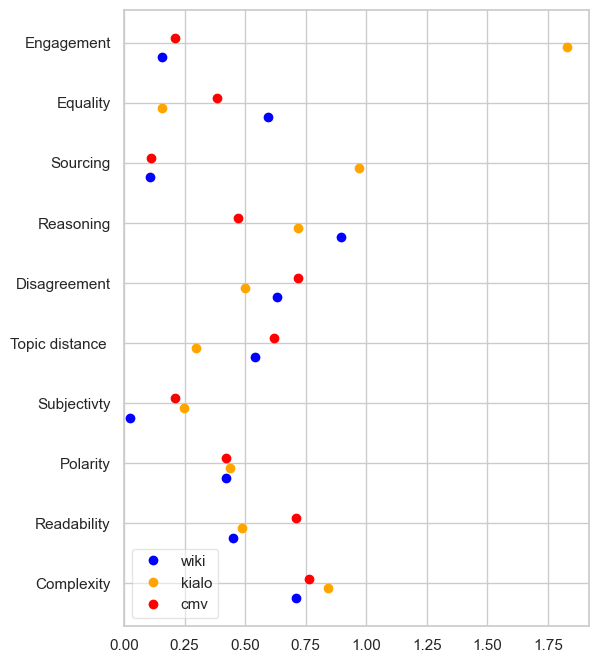

In [13]:
scores=['complexity_score','readability_score','polarity_score','subjectivity_score','topic_diversity_score',
        'disagreement_score','ROE_score','sourcing_score','equality_score','engagement_score']
labels = ['Complexity','Readability','Polarity','Subjectivty','Topic distance ','Disagreement','Reasoning','Sourcing','Equality','Engagement']
plot_dotplot_scores(scores_data_frame, scores,labels)